In [1]:
import os
import platform
from os import path as osp

import matplotlib.pyplot as plt
import numpy as np
from numpy import nanmean
import pandas as pd
import yaml

plt.rcParams['figure.facecolor'] = 'white'

In [2]:
if 'g2' in platform.node() or 'compute' in platform.node() or 'cpu' in platform.node():
    repo_dir = '/share/kuleshov/yzs2/TNP-pytorch/'
else:
    repo_dir = '/Users/yairschiff/Development/TNP-pytorch/'

In [3]:
exp_category = 'regression'
exp = 'gp'
max_num_ctx = [128, 256, 512, 1024, 2048]  # , 4096]
min_num_tar = [4]
models = ['canp', 'banp', 'anp', 'ipcanp', 'ipanp']

In [4]:
# Read hyperparams and results
args_file = 'args.yaml'
config_file = 'config.yaml'
eval_file = 'eval_rbf.log'
timing_file = 'timing.log'
exp_list = []
for maxc in max_num_ctx:
    for minc in [maxc // 2]: #min_num_ctx:
        for mt in min_num_tar:
            results_dir = osp.join(repo_dir, exp_category, 'results', f'{exp}', f'ctx-{minc}-{maxc}_tar-4-64')
            if not osp.exists(results_dir):
                continue
            for m in models:
                if not osp.exists(osp.join(results_dir, m)):
                    continue
                for v in os.listdir(osp.join(results_dir, m)):
                    if 'bak' in v:
                        continue
                    exp_dict = {}
                    # Parse args yaml:
                    try:
                        with open(osp.join(results_dir, m, v, args_file), 'r') as af:
                            try:
                                exp_dict = yaml.safe_load(af)
                            except yaml.YAMLError as exc:
                                print(exc)
                    except FileNotFoundError as fe:
                        print(fe)
                    # Parse timing
                    timing_dict = {}
                    try:
                        with open(osp.join(results_dir, m, v, timing_file), 'r') as ef:
                            for line in ef.readlines():
                                line_split = line.strip().split()
                                timing_dict[f'{line_split[0].lower()}_time'] = line_split[-1]
                        exp_dict.update(timing_dict)
                    except FileNotFoundError as fe:
                        print(fe)
                    # Parse eval
                    eval_dict = {}
                    try:
                        with open(osp.join(results_dir, m, v, eval_file), 'r') as ef:
                            for line in ef.readlines():
                                line_split = line.split()
                                eval_dict[line_split[1]] = line_split[line_split.index('tar_ll')+1]
                        exp_dict.update(eval_dict)
                    except FileNotFoundError as fe:
                        print(fe)
                    exp_list.append(exp_dict)
exp_df = pd.DataFrame(exp_list).rename(columns={'rbf': 'eval_ll'}).dropna(subset=['model']) 
exp_df = exp_df.astype({'eval_ll': 'float', 'avg_time': 'float', 'total_time': 'float'})
exp_df['avg_time'] = exp_df['avg_time']*1000
#(sorted(exp_list, key=lambda x: f'{x["model"]}-{x["expid"]}'))

[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/gp/ctx-512-1024_tar-4-64/banp/v0/timing.log'
[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/gp/ctx-512-1024_tar-4-64/banp/v0/eval_rbf.log'
[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/gp/ctx-512-1024_tar-4-64/banp/v1/timing.log'
[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/gp/ctx-512-1024_tar-4-64/banp/v1/eval_rbf.log'
[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/gp/ctx-512-1024_tar-4-64/banp/v2/timing.log'
[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/gp/ctx-512-1024_tar-4-64/banp/v2/eval_rbf.log'
[Errno 2] No such file or directory: '/share/kuleshov/yzs2/TNP-pytorch/regression/results/gp/ctx-512-1024_tar-4-64/banp/v3/timing.log'
[Errno 2] No such file or directory: '/share/kule

In [5]:
cols = ['model', 'expid', 
        'min_num_ctx', 'max_num_ctx',
        'num_induce', 'use_H_A', 'use_ABLA_induce',
        'eval_ll', 'total_time', 'avg_time']
exp_df_for_fig_unagg = exp_df[cols].sort_values(by=['min_num_ctx', 'model', 'expid', 'num_induce'])
# display(exp_df_for_fig_unagg)
exp_df_for_fig = exp_df_for_fig_unagg.groupby(['model', 'min_num_ctx'], as_index=False).agg({
    'eval_ll': ['mean','std'],
    'total_time': ['mean','std'],
    'avg_time': ['mean','std'],
    'min_num_ctx': ['first', 'count'],
    'max_num_ctx': 'first'
})
display(exp_df_for_fig)

model  eval_ll             total_time               avg_time            \
               mean       std         mean         std       mean       std   
0      anp  1.27248  0.006540  2208.496936   15.064776  22.084969  0.150648   
1      anp  1.32882  0.011897  1954.310304  336.448568  19.543103  3.364486   
2      anp  1.35238  0.004212  2300.458454  111.299216  23.004585  1.112992   
3      anp  1.35792  0.002019  3396.888756  232.547886  33.968888  2.325479   
4      anp  1.35976  0.000950  7830.389626  262.725727  78.303896  2.627257   
5     banp  1.29542  0.001184  2897.057461  162.780918  28.970575  1.627809   
6     banp  1.33874  0.001958  3143.593916  394.590489  31.435939  3.945905   
7     banp  1.35134  0.004386  6344.120302  114.162300  63.441203  1.141623   
8     banp      NaN       NaN          NaN         NaN        NaN       NaN   
9     banp      NaN       NaN          NaN         NaN        NaN       NaN   
10    canp  1.27378  0.012253  1418.314428  164.916314  14.183144  1.649163   
11    canp  1.32662  0.007588  1542.588016   46.806681  15.425880  0.468067   
12    canp  1.35078  0.005719  1687.672490  142.970426  16.876725  1.429704   
13    canp  1.35682  0.001750  2683.746547  133.525348  26.837465  1.335253   
14    canp  1.35952  0.000164  6168.784003  104.849481  61.687840  1.048495   
15   ipanp  1.31316  0.002517  2184.348908    9.725456  21.843489  0.097255   
16   ipanp  1.34420  0.001456  2151.842210  118.194972  21.518422  1.181950   
17   ipanp  1.35470  0.001208  2195.439050  134.994704  21.954391  1.349947   
18   ipanp  1.35564  0.001932  2600.848550  110.713509  26.008485  1.107135   
19   ipanp  1.35840  0.002092  4500.853534  266.236692  45.008535  2.662367   
20  ipcanp  1.31010  0.001920  1371.397368  127.999473  13.713974  1.279995   
21  ipcanp  1.34550  0.002457  1503.325656   34.121632  15.033257  0.341216   
22  ipcanp  1.35460  0.001214  1751.538761  171.199062  17.515388  1.711991   
23  ipcanp  1.35680  0.001772  2008.014933  180.800845  20.080149  1.808008   
24  ipcanp  1.35614  0.002472  3460.532632  150.545621  34.605326  1.505456   

   min_num_ctx       max_num_ctx  
         first count       first  
0           64     5         128  
1          128     5         256  
2          256     5         512  
3          512     5        1024  
4         1024     5        2048  
5           64     5         128  
6          128     5         256  
7          256     5         512  
8          512     5        1024  
9         1024     5        2048  
10          64     5         128  
11         128     5         256  
12         256     5         512  
13         512     5        1024  
14        1024     5        2048  
15          64     5         128  
16         128     5         256  
17         256     5         512  
18         512     5        1024  
19        1024     5        2048  
20          64     5         128  
21         128     5         256  
22         256     5         512  
23         512     5        1024  
24        1024     5        2048

In [6]:
# model_for_table = {'anp': 'ANP', 'banp': 'BANP', 'canp': 'CANP', 'ipcanp': 'CIPNP', 'ipanp': 'IPNP'}
# print('& \\multicolumn{5}{c}{\\textit{Context size range}}\\\\')
# print(' '.join([f'& [{maxc//2}, {maxc}]' for maxc in max_num_ctx]) + '\\\\')
# print('\\midrule')
# for m in models:
#     print('\\multirow[t]{2}{*}{' + model_for_table[m] + '}', end='')
#     for maxc in max_num_ctx:
#         max_eval_ll = exp_df_for_fig[exp_df_for_fig['max_num_ctx'] == maxc]['eval_ll'].max()
#         print(' &', end=' ')
#         eval_ll = exp_df_for_fig[(exp_df_for_fig['model'] == m) &
#                                  (exp_df_for_fig['max_num_ctx']==maxc)]['eval_ll'].item()
#         if np.isnan(eval_ll):
#             print('\\multirow[c]{2}{*}{OOM}', end='')
#         else:
#             if eval_ll == max_eval_ll:
#                 print('\\bf', end='')
#             print(f'{eval_ll:.3f}', end='')
#     print('\\\\\n', end='')
#     for maxc in max_num_ctx:
#         min_time = exp_df_for_fig[exp_df_for_fig['max_num_ctx'] == maxc]['total_time'].min()
#         print(' &', end=' ')
#         time = exp_df_for_fig[(exp_df_for_fig["model"]==m) &
#                                  (exp_df_for_fig["max_num_ctx"]==maxc)]["total_time"].item()
#         if not np.isnan(time):
#             if time == min_time:
#                 print('\\bf', end='')
#             print(f'{time:.2f}', end='')
#     print('\\\\\n\\midrule\n', end='')

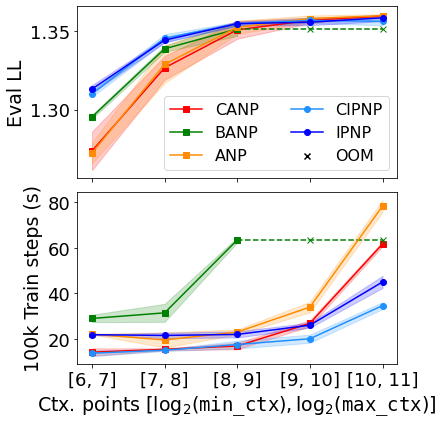

In [8]:
model_display_name = {'anp': 'ANP', 'banp': 'BANP', 'canp': 'CANP', 'ipcanp': 'CIPNP', 'ipanp': 'IPNP'}
colors = {'anp': 'darkorange', 'banp': 'green', 'canp': 'red', 'ipcanp': 'dodgerblue', 'ipanp': 'blue'}

x_label = r'Ctx. points $[\log_2(\mathtt{min\_ctx}), \log_2(\mathtt{max\_ctx})]$'
min_num_ctx = np.log2(np.array(exp_df_for_fig['min_num_ctx']['first'].unique()))
max_num_ctx = np.log2(np.array(exp_df_for_fig['max_num_ctx']['first'].unique()))
# min_num_ctx = np.log2(np.array(exp_df_for_fig['min_num_ctx'].unique()))
# max_num_ctx = np.log2(np.array(exp_df_for_fig['max_num_ctx'].unique()))

nan_found = False
fig, ax = plt.subplots(2, 1, sharex=True, tight_layout=True, figsize=(6, 6))
for m in models:
    eval_ll_mean = np.array(exp_df_for_fig.loc[exp_df_for_fig['model'] == m ]['eval_ll']['mean'])
    eval_ll_std = np.array(exp_df_for_fig.loc[exp_df_for_fig['model'] == m]['eval_ll']['std'])
    time_mean = np.array(exp_df_for_fig.loc[exp_df_for_fig['model'] == m]['avg_time']['mean'])
    time_std = np.array(exp_df_for_fig.loc[exp_df_for_fig['model'] == m]['avg_time']['std'])
#     eval_ll_mean = np.array(exp_df_for_fig.loc[exp_df_for_fig['model'] == m ]['eval_ll'])
#     time_mean = np.array(exp_df_for_fig.loc[exp_df_for_fig['model'] == m]['total_time'])
    ax[0].plot(min_num_ctx[~np.isnan(eval_ll_mean)],
               eval_ll_mean[~np.isnan(eval_ll_mean)],
               label=model_display_name[m],
               marker=('o' if 'ip' in m else 's'),
               color=colors[m])
    if np.isnan(eval_ll_mean).sum():
        nan_found = True
        ax[0].plot(np.concatenate([min_num_ctx[~np.isnan(eval_ll_mean)][-1:],
                                   min_num_ctx[np.isnan(eval_ll_mean)]]),
                   np.repeat([eval_ll_mean[~np.isnan(eval_ll_mean)][-1:]], np.isnan(eval_ll_mean).sum()+1),
                   linestyle='--',
                   marker='x',
                   color=colors[m])

    ax[0].fill_between(min_num_ctx, eval_ll_mean-eval_ll_std, eval_ll_mean+eval_ll_std,
                       color=colors[m],
                       alpha = 0.2)
    ax[1].plot(min_num_ctx[~np.isnan(time_mean)],
               time_mean[~np.isnan(time_mean)],
               label=model_display_name[m],
               marker=('o' if 'ip' in m else 's'),
               color=colors[m])
    if np.isnan(time_mean).sum():
        nan_found = True
        ax[1].plot(np.concatenate([min_num_ctx[~np.isnan(time_mean)][-1:],
                                   min_num_ctx[np.isnan(time_mean)]]),
                   np.repeat([time_mean[~np.isnan(time_mean)][-1:]], np.isnan(time_mean).sum()+1),
                   linestyle='--',
                   marker='x',
                   color=colors[m])
    ax[1].fill_between(min_num_ctx, time_mean-time_std, time_mean+time_std,
                       color=colors[m],
                       alpha = 0.2)
    

if nan_found:
    ax[0].scatter([], [], marker='x', color='black', label='OOM')
    ax[1].scatter([], [], marker='x', color='black', label='OOM')
# 
ax[0].legend(loc='best', ncol=2, fontsize=16)
# ax[0].set_xticks(ticks=min_num_ctx, labels=[f'[{int(minc):d}, {int(maxc):d}]'
#                                             for minc, maxc in zip (min_num_ctx, max_num_ctx)])
# ax[0].set_xlabel(x_label)
ax[0].set_ylabel('Eval LL', fontsize=19)
ax[0].tick_params(axis='y', labelsize=18)

# ax[1].legend(loc='best', fontsize=15.5)
ax[1].set_ylabel('100k Train steps (s)', fontsize=19)
ax[1].tick_params(axis='y', labelsize=18)
ax[1].set_xlabel(x_label, fontsize=19)
ax[1].set_xticks(ticks=min_num_ctx,
                 labels=[f'[{int(minc):d}, {int(maxc):d}]'
                         for minc, maxc in zip(min_num_ctx, max_num_ctx)],
                 fontsize=18)
plt.show()
fig.savefig(osp.join(repo_dir, exp_category, 'results', exp, 'NP_5seeds.pdf'))
fig.savefig(osp.join(repo_dir, exp_category, 'results', exp, 'NP_5seeds.svg'))